# Laura_Cavenati_864000_assignment3

## Introduction
The task of this assignment is the design of a CNN architecture and its training. The CNN has to be designed with the aim of reaching the maximum possible accuracy on the test set, with the hard constraint of a maximum of 7000 learnable parameters.

We use the MNIST dataset, a dataset of of handwritten digits images, consisting of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
The dataset can be easily downloaded directly from Keras.

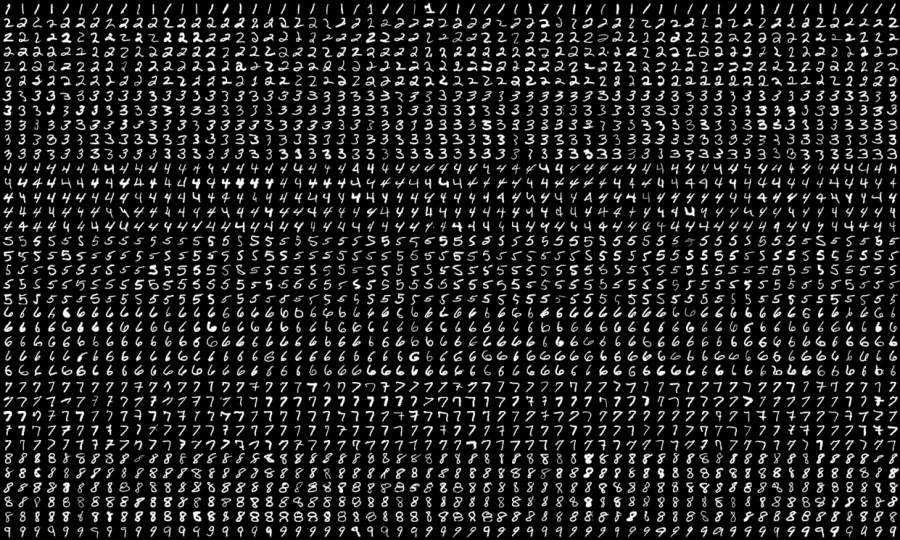


## Import Libraries

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Utility functions

In [ ]:
def plot_history(network_history):
    """The return value of the fit function is a keras.callbacks.History object which 
  contains the entire history of training/validation loss and accuracy, for each epoch."""


    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

## Data preparation

Since this dataset is provided with Keras, we just ask the keras.dataset model for training and test data.  
We download the data and normalize it between 0 and 1.  
Then we apply the to_categorical function from keras.utilis to convert integer labels to one-hot-vectors.

In [ ]:
num_classes = 10
input_shape = (28,28,1)

# load the data and divide it into train/test split
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data();

In [ ]:
# Model/data parameters
num_classes = 10
input_shape = (28,28,1)

# load the data and divide it into train/test split
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data();

# Scale images into the [0 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images with size (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Best model definition
Now I build a Convolutional Neural Network model.
The shape of the input layer equals the shape of the data, (28, 28, 1).
The second layer is a 2D convolution layer with 40 filters, a kernel size of 3×3, no padding, a stride of 1 and a ReLU as activation function.
Then there is a max pooling layer with pool size of 2x2.
Then there is another 2D convolution layer with 10 filters, a kernel size of 3×3, no padding, a stride of 1 and a ReLU as activation function.
Then there is another max pooling layer with pool size of 2x2, a flatten layer and a dropout layer with a fraction of the input units to drop of 0.5. 
The CNN is a multiple classifier so the output layer has 10 single node. This layer is a dense layer with the softmax as activation function.  

 INPUT | LAYER | OUTPUT | # PARAMETERS  
:---------:|:-----------:|:-----------:|:-----: 
28x28x1 | $C_1$: 3x3x1x40 | 26x26x40 | 400 
26x26x40 | $P_1$: max(2x2) | 13x13x40 | 0 
13x13x40 | $C_2$: 3x3x40x10 | 11x11x10 | 3610 
11x11x10 | $P_2$: max(2x2) | 5x5x10 | 0 
5x5x10 | Flatten | 1x250 | 0 
1x250 | Dropout | 1x250 | 0 
1x250 | Dense | 1x10 | 2510 

As we can see, the total number of parameters that is learned during the training process is 400+3610+2510=6520.

The first layers, convolution and pooling layers, perform feature extraction, whereas the fully connected layer, maps the extracted features into final output, such as classification.

Even if usally in the convolutional neural network initially the filters are spatially larger and less in number of channels and subsequently the number of channels increases but the spatial dimension decreases, I did it differently.
This because I must respect the constraint of a maximum of 7000 learnable parameters. If I swapped the two convolutional layers the parameters would increase.

I preferred to insert two convolutional layers rather than a single larger layer because it was demonstrated that a stack of smaller convolutional filters has the same receptive field as one bigger but makes the CNN deeper, with more non linearities and with fewer parameters.

I insert only one fully connected layer at the end of the model because it is very expensive in term of learnable parameters.

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(40, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(10, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 40)        400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 10)        3610      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2

To fit the model, I adopt categorical_crossentropy as a loss function, adam as optimizer (default hyper-parameters: learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), accuracy as metrics, 15 epochs, a batch size of 128. The fraction of the training data used as validation data is 0.2.

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
CNN_history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation), verbose=0)

We can therefore plot the behaviour of training and validation loss and accuracy.

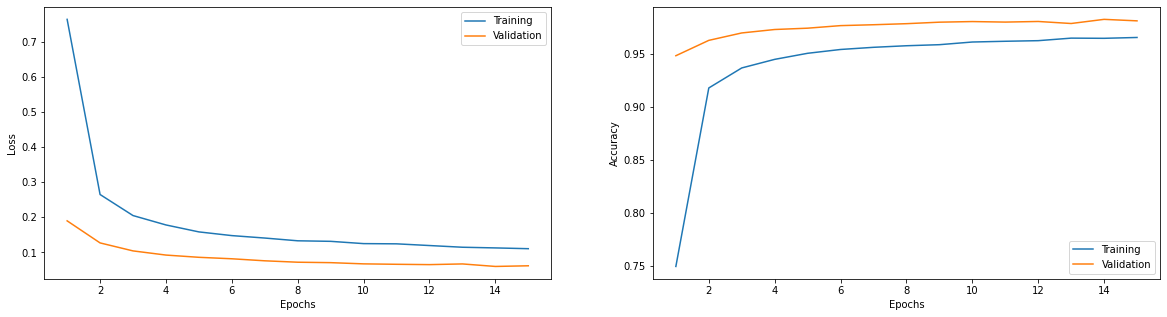

In [ ]:
x_plot = list(range(1, epochs+1))
plot_history(CNN_history)

From the left graph we can see that the learning rate is good. The model no longer learns after 10 epochs; perhaps it would be good to reduce the learning rate so that the model can learn more.  
From the right graph we can see that there isn't overfitting. The validation accuracy is better than the training accuracy.

In [ ]:
"""Evaluate the model on the test set"""
score = model.evaluate(x_test, y_test, verbose=0)

print("final train loss:", round(CNN_history.history['loss'][-1], 5))
print("final validation loss:", round(CNN_history.history['val_loss'][-1], 5))
print("Test loss:", round(score[0], 5),"\n")
print("final train accuracy:", round(CNN_history.history['accuracy'][-1], 5))
print("final validation accuracy:", round(CNN_history.history['val_accuracy'][-1], 5))
print("Test accuracy:", round(score[1], 5))

final train loss: 0.11044
final validation loss: 0.06175
Test loss: 0.04196 

final train accuracy: 0.96581
final validation accuracy: 0.9815
Test accuracy: 0.9867


# Comments and conclusion
 
In the appendix I insert other models, for completeness and to make a comparison.  
Even if I use only 6520 parameters, the final accuracy on the test set is very high compared to that of the smaller model with only 20 parameters.  
Furthermore, this accuracy is only slightly lower than that obtained in class with a model with 34826 parameters.  
If I build a deeper model, always with the hard constraint of a maximum of 7000 learnable parameters, the accuracy decreases a little.  
If instead I build a model with only one convolutional layer but spatially larger, (always with the hard constraint of a maximum of 7000 learnable parameters), the accuracy is about equal to to that of the model I have chosen.

## Appendix

### Smallest model


In [ ]:
model_smallest = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.MaxPooling2D(pool_size=(28, 28)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_smallest.summary()

"""Train the model"""
model_smallest.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model_smallest.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation), verbose=0)

"""Evaluate the model on the test set"""
score = model_smallest.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
Test loss: 2.300983428955078
Test accuracy: 0.11349999904632568


### Deeper model

In [ ]:
model_deeper = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(35, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(15, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(10, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_deeper.summary()

"""Train the model"""
model_deeper.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_deeper.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation), verbose=0)

"""Evaluate the model on the test set"""
score = model_deeper.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 35)        350       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 35)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 15)        4740      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 10)          1360      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10)               

### Model with one larger convolutional layer

In [ ]:
model_biggerc = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(5, kernel_size=(7, 7), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_biggerc.summary()

"""Train the model"""
model_biggerc.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_biggerc.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation), verbose=0)

"""Evaluate the model on the test set"""
score = model_biggerc.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 22, 22, 5)         250       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 5)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 605)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 605)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                6060      
Total params: 6,310
Trainable params: 6,310
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.05566884204745293
Test accuracy: 0.982699990272522


### Lecture's model 

In [ ]:
model_lecture = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_lecture.summary()

"""Train the model"""
model_lecture.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_lecture.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation), verbose=0)

"""Evaluate the model on the test set"""
score = model_lecture.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

**Per convertire .ipynb in formato html**

In [ ]:
#!pip install nbconvert;
#If you use an Anaconda Python distribution, nbconvert is most likely already installed.

In [ ]:
!jupyter nbconvert --to html Laura_Cavenati_864000_assignment3.ipynb;
#per eseguire questo comando devo fare in modo che il file .ipynb sia uplodato nei files (vedi riquadro a sinistra)

[NbConvertApp] Converting notebook Laura_Cavenati_864000_assignment3.ipynb to html
[NbConvertApp] Writing 1180075 bytes to Laura_Cavenati_864000_assignment3.html
